In [6]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# !pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2022-06-16 18:04:06.888217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 18:04:06.888276: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-06-16 18:04:08.847392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-06-16 18:04:08.847607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-06-16 18:04:08.847628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.10.0-dev20220615


In [7]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [8]:
data_set=pd.read_table(train_file_path,sep="\t",header=None,names=["label","message"])

In [9]:
data_set.head()

label                                            message
0   ham  ahhhh...just woken up!had a bad dream about u ...
1   ham                           you can never do nothing
2   ham  now u sound like manky scouse boy steve,like! ...
3   ham  mum say we wan to go then go... then she can s...
4   ham  never y lei... i v lazy... got wat? dat day ü ...

## Exploring the data set

In [10]:
data_set.shape

(4179, 2)

In [11]:
data_set.isnull().sum()

label      0
message    0
dtype: int64

In [12]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4179 non-null   object
 1   message  4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [13]:
data_set.describe()

label                 message
count   4179                    4179
unique     2                    3935
top      ham  sorry, i'll call later
freq    3619                      22

## Exploring more the data set

In [14]:
len_ham=data_set["label"][data_set.label=="ham"]
len_spam=data_set["label"][data_set.label=="spam"]

ham messages length is 3619
spam messages length is 560


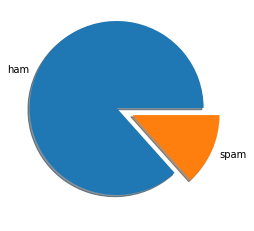

In [15]:
print("ham messages length is %d"%len(len_ham))
print("spam messages length is %d"%len(len_spam))
arr=np.array([len(len_ham),len(len_spam)])
labels=["ham","spam"]
plt.pie(arr,labels=labels,explode=[0.2,0.0],shadow=True)
plt.show()
# here data is inbalanced .. the model will learn from ham messages more than spam messages

## data preprocessing... text preprocessing

In [16]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
def text_preprocessing(text):
    """ batter to user NLTK stemming"""
    ps = PorterStemmer()
    txt=str(text).lower()
    words = word_tokenize(txt)
    return ''.join(words)

In [17]:
# importing modules
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

sentence = "Programmers program with programming languages"
words = word_tokenize(sentence)
print(words)

['Programmers', 'program', 'with', 'programming', 'languages']


In [18]:
data_set["new message"]=data_set["message"].apply(lambda x:text_preprocessing(x))
data_set.head()

label                                            message  \
0   ham  ahhhh...just woken up!had a bad dream about u ...   
1   ham                           you can never do nothing   
2   ham  now u sound like manky scouse boy steve,like! ...   
3   ham  mum say we wan to go then go... then she can s...   
4   ham  never y lei... i v lazy... got wat? dat day ü ...   

                                         new message  
0  ahhhh...justwokenup!hadabaddreamaboututho,soid...  
1                               youcanneverdonothing  
2  nowusoundlikemankyscouseboysteve,like!iistrave...  
3  mumsaywewantogothengo...thenshecanshunbianwatc...  
4  neverylei...ivlazy...gotwat?datdayüsendmedaurl...

# features encoding

In [19]:
data_set['label']=data_set.label.map({"ham":0,"spam":1})
data_set.head()

label                                            message  \
0      0  ahhhh...just woken up!had a bad dream about u ...   
1      0                           you can never do nothing   
2      0  now u sound like manky scouse boy steve,like! ...   
3      0  mum say we wan to go then go... then she can s...   
4      0  never y lei... i v lazy... got wat? dat day ü ...   

                                         new message  
0  ahhhh...justwokenup!hadabaddreamaboututho,soid...  
1                               youcanneverdonothing  
2  nowusoundlikemankyscouseboysteve,like!iistrave...  
3  mumsaywewantogothengo...thenshecanshunbianwatc...  
4  neverylei...ivlazy...gotwat?datdayüsendmedaurl...

# split data for training and testing

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data_set["new message"],data_set["label"],random_state=1)
print("all data rows %d"%(data_set.shape[0]))
print("train data rows %d"%(X_train.shape[0]))
print("test data rows %d"%(X_test.shape[0]))

all data rows 4179
train data rows 3134
test data rows 1045


# text to numbres

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
countVectorizer=CountVectorizer()
training_data=countVectorizer.fit_transform(X_train)
testing_data=countVectorizer.transform(X_test)

In [22]:
training_data

<3134x8019 sparse matrix of type '<class 'numpy.int64'>'
	with 10596 stored elements in Compressed Sparse Row format>

# making the model

In [23]:
from sklearn.naive_bayes import MultinomialNB
_naive_bayes=MultinomialNB()
_naive_bayes.fit(training_data,y_train)

MultinomialNB()

# predicting from test data

In [24]:
predictions=_naive_bayes.predict(testing_data)
predictions

array([0, 0, 1, ..., 0, 0, 0])

# accurancy and testing our model

In [25]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print("Accuracy %s"%(str(accuracy_score(y_test,predictions))))
print("Precision %s"%(str(precision_score(y_test,predictions))))
print("Recall %s"%(str(recall_score(y_test,predictions))))
print("F1 score %s"%(str(f1_score(y_test,predictions))))

Accuracy 0.9464114832535885
Precision 0.9896907216494846
Recall 0.6357615894039735
F1 score 0.7741935483870968


In [26]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
    seri=pd.Series(pred_text)
    num=countVectorizer.transform(seri)
    prediction=_naive_bayes.predict(num)
    p="ham"
    if prediction[0]==1:
        p="spam"
    return p


In [27]:
pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

ham


In [28]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
    test_messages = ["how are you doing today","sale today! to stop texts call 98912460324","i dont want to go. can we try it a different day? available sat","our new mobile video service is live. just install on your phone to start watching.","you have won £1000 cash! call to claim your prize.","i'll bring it tomorrow. don't forget the milk.","wow, is your arm alright. that happened to me one time too"]
    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    passed = True
    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        if prediction != ans:
            passed = False
    if passed:
        print("You passed the challenge. Great job!")
    else:
        print("You haven't passed yet. Keep trying.")

In [29]:
test_predictions()

You haven't passed yet. Keep trying.
